# **IMPORTADO DE MÓDULOS/FUNCIONES/DATA**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d


import tensorflow as tf
tf.version.VERSION
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import initializers
from keras.regularizers import l2

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

2024-08-06 15:25:55.847829: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-06 15:25:55.873931: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-06 15:25:56.250223: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


cuda


In [2]:
from functions import momentos, gauss, gauss_fit, get_mean_pulse_from_set, delay_pulse_pair, move_to_reference, create_and_delay_pulse_pair, create_position, calculate_gaussian_center_sigma, normalize, plot_gaussian_and_get_params, normalize_given_params, set_seed
from Models import MLP_Torch, train_loop_MLP

In [3]:
#data = np.load('/home/josea/pulsos_Na22_filt_norm_practica_polyfit.npz')['data']
data = np.load('/home/josea/PRUEBA_Co60.npz')['data']

## **INTERPOLATE**

In [4]:
#--------------------------------Interpolar pulsos reales---------------------------------
EXTRASAMPLING = 8
Nt = np.shape(data)[1]
Nt_new = Nt *  EXTRASAMPLING
time_step = 0.2
new_time_step = time_step / EXTRASAMPLING

tiempo = np.linspace(0, Nt, Nt)
tiempo_new = np.linspace(0,Nt,Nt_new)

interp_func = interp1d(tiempo, data,  kind = 'cubic', axis = 1)
new_data = interp_func(tiempo_new)

print('Number of time points: %.d' % (Nt))
print('Time step: %.2f' % (time_step))
print('New number of time points: %.d' % (Nt_new))
print('New time step: %.4f' % (new_time_step))

#-------------------------------------------- Align the pulses -----------------------------------
align_steps = 20
new_data[:,:,1] = np.roll(new_data[:,:,1], align_steps)
new_data[:,:align_steps,1] = np.random.normal(scale = 1e-3, size = align_steps)


Number of time points: 600
Time step: 0.20
New number of time points: 4800
New time step: 0.0250


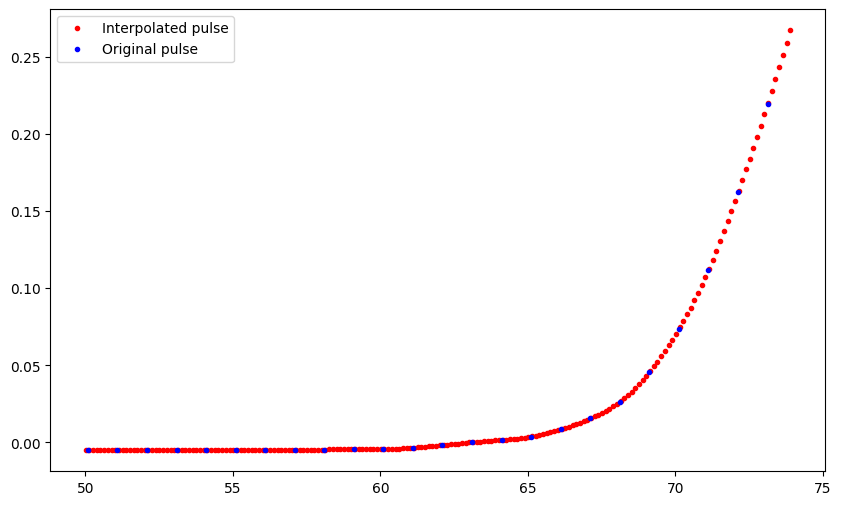

In [5]:
start = 50*EXTRASAMPLING
stop = 74*EXTRASAMPLING

plt.figure(figsize = (10,6))

plt.plot(tiempo_new[start:stop],new_data[0,start:stop,0],'r.')
plt.plot(tiempo[50:74], data[0,50:74,0],'b.')
plt.legend(('Interpolated pulse','Original pulse'))

# **DEFINITIONS**

In [6]:
Ajuste_grueso = 1  # 0 = YES, 1 = NO
delay_steps = 30  # Max number of steps to delay pulses
moments_order = 6  # Max order of moments used
nbins = 51 #Num bins for all histograms
create_positions = 0 # Wether to create new_source positions. (0 = YES, 1 = NO)                           
t_shift = 8 #Time steps to move for the new positions
epochs = 500 
normalization_method = 'min-max'

#new_data= new_data[np.random.permutation(new_data.shape[0]), :, :]
set_seed(42) #Fix seeds
Num_Neurons = 32
lr = 1e-4

# Train/test set split
train_data = new_data[:3800,:,:]
test_data = new_data[3800:,:,:]
print('Número de casos de entrenamiento: ', train_data.shape[0])
print('Número de casos de test: ', test_data.shape[0])

Número de casos de entrenamiento:  3800
Número de casos de test:  656


# **DETECTORS**

In [7]:
# Create train set
if Ajuste_grueso == 0:
    
    # Calculate mean pulse in detector 
    mean_dec0 = get_mean_pulse_from_set(train_data, channel = 0)
    mean_dec1 = get_mean_pulse_from_set(train_data, channel = 1)

    # Move rest of the pulses to align with mean 
    delays_dec0, moved_pulses_dec0 = move_to_reference(mean_dec0, train_data, start = start, stop = stop, max_delay = int(stop-start), channel = 0)
    delays_dec1, moved_pulses_dec1 = move_to_reference(mean_dec1, train_data, start = start, stop = stop, max_delay = int(stop-start), channel = 1)

   
    trainX_dec0, REF_train_dec0 = create_and_delay_pulse_pair(moved_pulses_dec0, new_time_step, delay_steps = delay_steps, NOISE = False)
    trainX_dec1, REF_train_dec1 = create_and_delay_pulse_pair(moved_pulses_dec1, new_time_step, delay_steps = delay_steps, NOISE = False)

if Ajuste_grueso == 1:
    

    trainX_dec0, REF_train_dec0 = create_and_delay_pulse_pair(train_data[:,start:stop,0], new_time_step, delay_steps = delay_steps, NOISE = False)
    trainX_dec1, REF_train_dec1 = create_and_delay_pulse_pair(train_data[:,start:stop,1], new_time_step, delay_steps = delay_steps, NOISE = False)

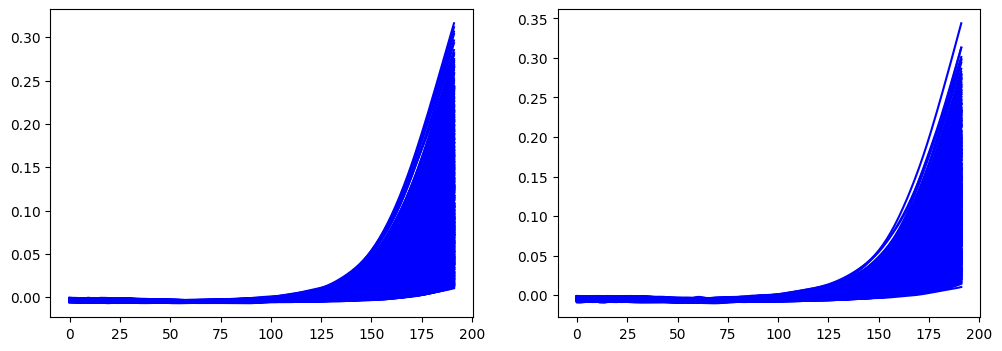

In [8]:
# Plot
plt.figure(figsize = (12,4))

plt.subplot(121)
for i in range(1000):
    plt.plot(trainX_dec0[i,:,0],'b-')
plt.subplot(122)
for i in range(1000):
    plt.plot(trainX_dec1[i,:,0],'b-')

In [9]:
#-------------------------------------------------------------- Calculate moments ------------------------------------------
M_Train_dec0 = momentos(trainX_dec0, order = moments_order)
M_Train_dec1 = momentos(trainX_dec1, order = moments_order)

#-------------------------------------------------------------- Normalize ---------------------------------------------------
M_Train_dec0, params_dec0 =  normalize(M_Train_dec0, method = normalization_method)
M_Train_dec1, params_dec1 =  normalize(M_Train_dec1, method = normalization_method)

#-------------------------------------------------------------- Print information ---------------------------------------------------
NM = np.shape(M_Train_dec0)[1]
print(M_Train_dec0.shape, "NM =", NM)
print("Normalization parameters detector 0:", params_dec0)

NM = np.shape(M_Train_dec1)[1]
print(M_Train_dec1.shape, "NM =", NM)
print("Normalization parameters detector 1:", params_dec1)

(3800, 6, 2) NM = 6
Normalization parameters detector 0: (array([-0.59037584, -0.21703806, -0.08446715, -0.02463465,  0.00732137,
        0.02550775]), array([9.21233292, 8.53048929, 7.76744566, 7.09737441, 6.52248194,
       6.02839152]))
(3800, 6, 2) NM = 6
Normalization parameters detector 1: (array([-0.75035392, -0.27204374, -0.11697501, -0.04513164, -0.0047014 ,
        0.01924537]), array([8.20157933, 7.71131143, 7.06060839, 6.47540144, 5.96932863,
       5.53280554]))


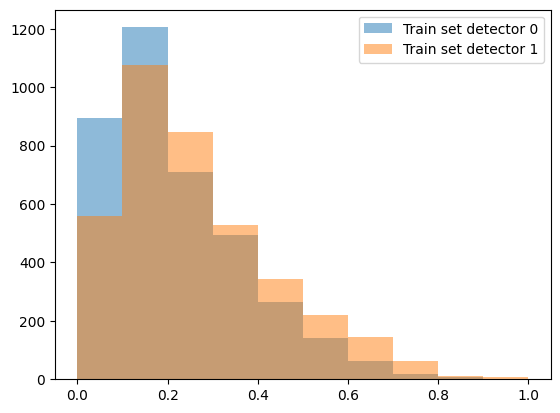

In [10]:
plt.hist(M_Train_dec0[:,0,0], alpha = 0.5, label = 'Train set detector 0');
plt.hist(M_Train_dec1[:,0,0], alpha = 0.5, label = 'Train set detector 1');
plt.legend()

# **FULL TOF**

In [11]:
# Create test set 
if Ajuste_grueso == 0:
    
    delays_test_dec0, moved_pulses_test_dec0 = move_to_reference(mean_dec0, test_data, start = start, stop = stop, max_delay = int(stop - start), channel = 0)
    delays_test_dec1, moved_pulses_test_dec1 = move_to_reference(mean_dec1, test_data, start = start, stop = stop, max_delay = int(stop - start), channel = 1)
 
    TEST_00 = np.stack((moved_pulses_test_dec0, moved_pulses_test_dec1), axis = 2)
    TEST_02 = create_position(TEST_00, channel_to_move = 1, channel_to_fix = 0, t_shift = t_shift, NOISE = False)
    TEST_20 = create_position(TEST_00, channel_to_move = 0, channel_to_fix = 1, t_shift = t_shift, NOISE = False)
    TEST_04 = create_position(TEST_00, channel_to_move = 1, channel_to_fix = 0, t_shift = int(2*t_shift), NOISE = False)
    TEST_40 = create_position(TEST_00, channel_to_move = 0, channel_to_fix = 1, t_shift = int(2*t_shift), NOISE = False)

if Ajuste_grueso == 1:

    if create_positions == 1:
        TEST = test_data[:,start:stop,:]
    
    if create_positions == 0:
        TEST_00 = test_data[:,start:stop,:]
        TEST_02 = create_position(TEST_00, channel_to_move = 1, channel_to_fix = 0, t_shift = t_shift, NOISE = False)
        TEST_20 = create_position(TEST_00, channel_to_move = 0, channel_to_fix = 1, t_shift = t_shift, NOISE = False)
        TEST_04 = create_position(TEST_00, channel_to_move = 1, channel_to_fix = 0, t_shift = int(2*t_shift), NOISE = False)
        TEST_40 = create_position(TEST_00, channel_to_move = 0, channel_to_fix = 1, t_shift = int(2*t_shift), NOISE = False)
        TEST = np.concatenate((TEST_02, TEST_00, TEST_20, TEST_04, TEST_40), axis = 0)



MOMENTS_TEST = momentos(TEST, order = moments_order)
MOMENTS_TEST_norm_dec0 = normalize_given_params(MOMENTS_TEST, params_dec0, channel = 0, method = normalization_method)
MOMENTS_TEST_norm_dec1 = normalize_given_params(MOMENTS_TEST, params_dec1, channel = 1, method = normalization_method)
MOMENTS_TEST = np.stack((MOMENTS_TEST_norm_dec0, MOMENTS_TEST_norm_dec1), axis = -1)

In [12]:
model_dec0 = MLP_Torch(NM = NM, NN = Num_Neurons, STD_INIT = 0.5)
model_dec1 = MLP_Torch(NM = NM, NN = Num_Neurons, STD_INIT = 0.5)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

# Print the number of parameters
num_params = count_parameters(model_dec0)
print(f"Total number of parameters: {num_params}")

Total number of parameters: 2369


In [13]:
# Create Dataset
train_dataset_dec0 = torch.utils.data.TensorDataset(torch.from_numpy(M_Train_dec0).float(), torch.from_numpy(np.expand_dims(REF_train_dec0, axis = -1)).float())
train_dataset_dec1 = torch.utils.data.TensorDataset(torch.from_numpy(M_Train_dec1).float(), torch.from_numpy(np.expand_dims(REF_train_dec1, axis = -1)).float())

# Create DataLoaders
train_loader_dec0 = torch.utils.data.DataLoader(train_dataset_dec0, batch_size = 32, shuffle = True)
train_loader_dec1 = torch.utils.data.DataLoader(train_dataset_dec1, batch_size = 32, shuffle = True)

optimizer_dec0 = torch.optim.AdamW(model_dec0.parameters(), lr = lr) 
optimizer_dec1 = torch.optim.AdamW(model_dec1.parameters(), lr = lr)   

In [14]:
# Execute train loop
loss_dec0, test_dec0 = train_loop_MLP(model_dec0, optimizer_dec0, train_loader_dec0, torch.tensor(MOMENTS_TEST[:,:,0]).float(), EPOCHS = epochs, save = False) 
loss_dec1, test_dec1 = train_loop_MLP(model_dec1, optimizer_dec1, train_loader_dec1, torch.tensor(MOMENTS_TEST[:,:,1]).float(), EPOCHS = epochs, save = False)

EPOCH 1:
LOSS train 2.468757204080032
EPOCH 2:
LOSS train 0.3645136397079391
EPOCH 3:
LOSS train 0.07889511541984344
EPOCH 4:
LOSS train 0.02982047068791748
EPOCH 5:
LOSS train 0.014370507592240633
EPOCH 6:
LOSS train 0.0091727433047431
EPOCH 7:
LOSS train 0.006903397116683803
EPOCH 8:
LOSS train 0.005453607821205663
EPOCH 9:
LOSS train 0.004350154562971665
EPOCH 10:
LOSS train 0.003524437728259018
EPOCH 11:
LOSS train 0.0028874862138024075
EPOCH 12:
LOSS train 0.0022600907186180416
EPOCH 13:
LOSS train 0.0016686359590108869
EPOCH 14:
LOSS train 0.0012712615965845822
EPOCH 15:
LOSS train 0.0010394485555372153
EPOCH 16:
LOSS train 0.000881581275449608
EPOCH 17:
LOSS train 0.0007691014601485962
EPOCH 18:
LOSS train 0.0006875958635523063
EPOCH 19:
LOSS train 0.0006285902537934292
EPOCH 20:
LOSS train 0.0005832518806327845
EPOCH 21:
LOSS train 0.0005463937590844827
EPOCH 22:
LOSS train 0.0005145977213988633
EPOCH 23:
LOSS train 0.00048793972000258707
EPOCH 24:
LOSS train 0.0004653971689364

In [15]:
if Ajuste_grueso == 0:

        TOFN_V02 = (test_dec0[:,:TEST_00.shape[0]] - new_time_step*delays_test_dec0) - (test_dec1[:,:TEST_00.shape[0]] - new_time_step*delays_test_dec1)
        TOFN_V00 = (test_dec0[:,TEST_00.shape[0] : 2*TEST_00.shape[0]] - new_time_step*delays_test_dec0) - (test_dec1[:,TEST_00.shape[0] : 2*TEST_00.shape[0]] - new_time_step*delays_test_dec1)
        TOFN_V20 = (test_dec0[:,2*TEST_00.shape[0] :3*TEST_00.shape[0]]  - new_time_step*delays_test_dec0) - (test_dec1[:,2*TEST_00.shape[0] :3*TEST_00.shape[0]] - new_time_step*delays_test_dec1)
        TOFN_V04 = (test_dec0[:,3*TEST_00.shape[0] :4*TEST_00.shape[0]]  - new_time_step*delays_test_dec0) - (test_dec1[:,3*TEST_00.shape[0] :4*TEST_00.shape[0]] - new_time_step*delays_test_dec1)
        TOFN_V40 = (test_dec0[:,4*TEST_00.shape[0]:]  - new_time_step*delays_test_dec0) - (test_dec1[:,4*TEST_00.shape[0]:] - new_time_step*delays_test_dec1)
    
if Ajuste_grueso == 1:
        
        if create_positions == 1:
                TOFN_V28 = test_dec0[:,:V28.shape[0]] - test_dec1[:,:V28.shape[0]]
                TOFN_V55 = test_dec0[:,V28.shape[0] :V28.shape[0] + V55.shape[0]] - test_dec1[:,V28.shape[0] :V28.shape[0] + V55.shape[0]]
                TOFN_V82 = test_dec0[:,V28.shape[0] + V55.shape[0]:] - test_dec1[:,V28.shape[0] + V55.shape[0]:]
        
        if create_positions == 0:
                TOFN_V02 = test_dec0[:,:TEST_00.shape[0]] - test_dec1[:,:TEST_00.shape[0]]
                TOFN_V00 = test_dec0[:,TEST_00.shape[0] : 2*TEST_00.shape[0]] - test_dec1[:, TEST_00.shape[0] : 2*TEST_00.shape[0]]
                TOFN_V20 = test_dec0[:,2*TEST_00.shape[0] :3*TEST_00.shape[0]] - test_dec1[:,2*TEST_00.shape[0] :3*TEST_00.shape[0]]
                TOFN_V04 = test_dec0[:,3*TEST_00.shape[0] :4*TEST_00.shape[0]] - test_dec1[:,3*TEST_00.shape[0] :4*TEST_00.shape[0]]
                TOFN_V40 = test_dec0[:,4*TEST_00.shape[0]:] - test_dec1[:,4*TEST_00.shape[0]:]
    
# Calulate Validation error
if create_positions == 1:
    
    # Calculate centered position 'centroid'
    centroid_V55, sigmaN_V55 = calculate_gaussian_center_sigma(TOFN_V55, np.zeros((TOFN_V55.shape[0])),  nbins = nbins)  
    
    error_V28 = abs((TOFN_V28 - centroid_V55[:, np.newaxis] + 0.2))
    error_V55 = abs((TOFN_V55 - centroid_V55[:, np.newaxis]))
    error_V82 = abs((TOFN_V82 - centroid_V55[:, np.newaxis] - 0.2))
    Error = np.concatenate((error_V28, error_V55, error_V82), axis = 1)

if create_positions == 0:
    # Calculate centered position 'centroid'
    centroid_V00, sigmaN_V00 = calculate_gaussian_center_sigma(TOFN_V00, np.zeros((TOFN_V00.shape[0])), nbins = nbins) 
    
    error_V02 = abs((TOFN_V02 - centroid_V00[:, np.newaxis] + 0.2))
    error_V00 = abs((TOFN_V00 - centroid_V00[:, np.newaxis]))
    error_V20 = abs((TOFN_V20 - centroid_V00[:, np.newaxis] - 0.2))
    error_V04 = abs((TOFN_V04 - centroid_V00[:, np.newaxis] + 0.4))
    error_V40 = abs((TOFN_V40 - centroid_V00[:, np.newaxis] - 0.4))
    
    Error = np.concatenate((error_V02, error_V00, error_V20, error_V04, error_V40), axis = 1)   

261 0.050969073332710585


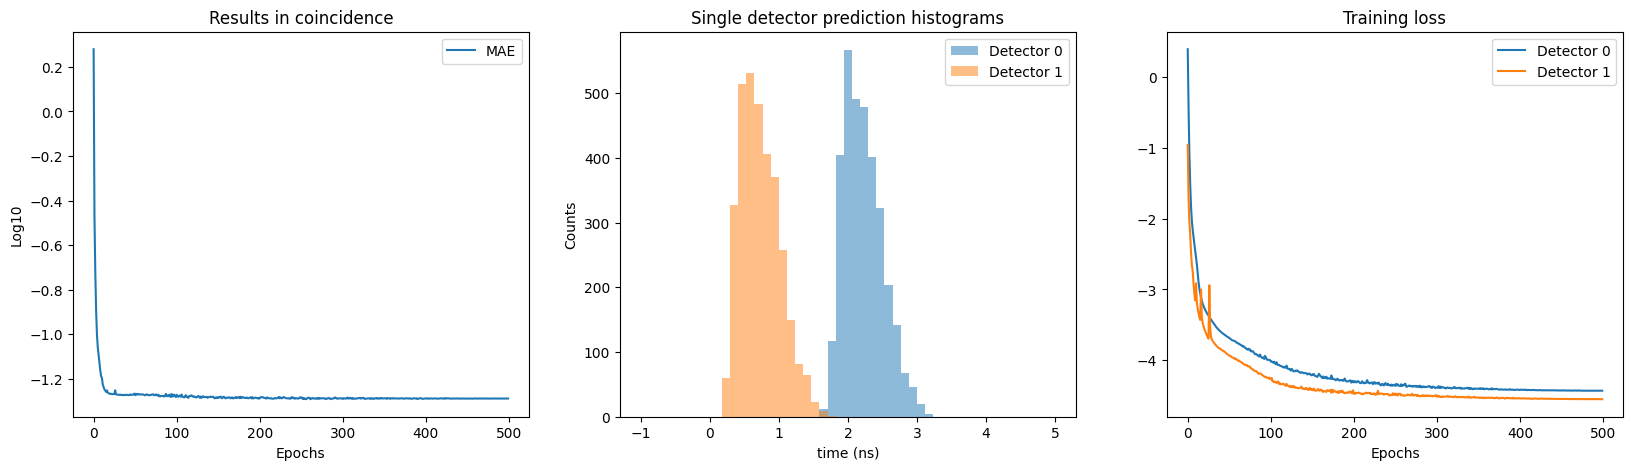

In [16]:
# Print MAE
MAE = np.mean(Error, axis = 1)
idx_min_MAE = np.where(MAE == np.min(MAE))[0][0]
print(idx_min_MAE, np.min(MAE))

# PLot
plt.figure(figsize = (20,5))
plt.subplot(131)
plt.plot(np.log10(MAE[:].astype('float64')), label = 'MAE')
plt.title('Results in coincidence')
plt.xlabel('Epochs')
plt.ylabel('Log10')
plt.legend()

plt.subplot(132)
if Ajuste_grueso == 0:
    plt.hist(test_dec0[idx_min_MAE , :delays_test_dec0.shape[0]] - new_time_step*delays_test_dec0, bins = nbins, range = [-1, 3], alpha = 0.5, label = 'Detector 0');
    plt.hist(test_dec1[idx_min_MAE , :delays_test_dec1.shape[0]] - new_time_step*delays_test_dec1, bins = nbins, range = [-1, 3], alpha = 0.5, label = 'Detector 1');

if Ajuste_grueso == 1:
    plt.hist(test_dec0[idx_min_MAE , :], bins = nbins, range = [-1, 5], alpha = 0.5, label = 'Detector 0');
    plt.hist(test_dec1[idx_min_MAE , :], bins = nbins, range = [-1, 5], alpha = 0.5, label = 'Detector 1');

plt.title('Single detector prediction histograms')
plt.xlabel('time (ns)')
plt.ylabel('Counts')
plt.legend()

plt.subplot(133)
plt.plot(np.log10(loss_dec0.astype('float32')), label = 'Detector 0')
plt.plot(np.log10(loss_dec1.astype('float32')), label = 'Detector 1')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.legend()


V40: CENTROID(ns) = 0.398  FWHM(ns) = 0.153  std(ns) = 0.065
V82: CENTROID(ns) = 0.199  FWHM(ns) = 0.148  std(ns) = 0.063
V55: CENTROID(ns) = -0.000  FWHM(ns) = 0.152  std(ns) = 0.065
V28: CENTROID(ns) = -0.199  FWHM(ns) = 0.150  std(ns) = 0.064
V04: CENTROID(ns) = -0.400  FWHM(ns) = 0.150  std(ns) = 0.064


Text(0, 0.5, 'Counts')

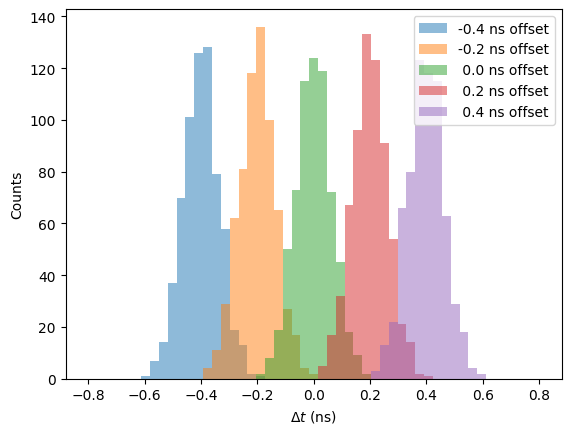

In [19]:
epoch = idx_min_MAE  
#------------------------------------------- Histogram and gaussian fit -----------------------------------------------
if create_positions == 1:
    HN, AN, x0N_V28, sigmaN_V28, FWHMN_V28 = plot_gaussian_and_get_params(TOFN_V28[epoch,:], centroid_V55[epoch], range = 0.8, label = '-0.2 ns offset', nbins = nbins)
    HN, AN, x0N_V55, sigmaN_V55, FWHMN_V55 = plot_gaussian_and_get_params(TOFN_V55[epoch,:], centroid_V55[epoch], range = 0.8, label = ' 0.0 ns offset', nbins = nbins)
    HN, AN, x0N_V82, sigmaN_V82, FWHMN_V82 = plot_gaussian_and_get_params(TOFN_V82[epoch,:], centroid_V55[epoch], range = 0.8, label = ' 0.2 ns offset', nbins = nbins)
   

    print('')
    print("V82: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V82, FWHMN_V82, sigmaN_V82))
    print("V55: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V55, FWHMN_V55, sigmaN_V55))
    print("V28: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V28, FWHMN_V28, sigmaN_V28))

if create_positions == 0:    
    HN, AN, x0N_V04, sigmaN_V04, FWHMN_V04 = plot_gaussian_and_get_params(TOFN_V04[epoch,:], centroid_V00[epoch], range = 0.8, label = '-0.4 ns offset', nbins = nbins)
    HN, AN, x0N_V28, sigmaN_V28, FWHMN_V28 = plot_gaussian_and_get_params(TOFN_V02[epoch,:], centroid_V00[epoch], range = 0.8, label = '-0.2 ns offset', nbins = nbins)
    HN, AN, x0N_V55, sigmaN_V55, FWHMN_V55 = plot_gaussian_and_get_params(TOFN_V00[epoch,:], centroid_V00[epoch], range = 0.8, label = ' 0.0 ns offset', nbins = nbins)
    HN, AN, x0N_V82, sigmaN_V82, FWHMN_V82 = plot_gaussian_and_get_params(TOFN_V20[epoch,:], centroid_V00[epoch], range = 0.8, label = ' 0.2 ns offset', nbins = nbins)
    HN, AN, x0N_V40, sigmaN_V40, FWHMN_V40 = plot_gaussian_and_get_params(TOFN_V40[epoch,:], centroid_V00[epoch], range = 0.8, label = ' 0.4 ns offset', nbins = nbins)

    print('')
    print("V40: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V40, FWHMN_V40, sigmaN_V40))
    print("V82: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V82, FWHMN_V82, sigmaN_V82))
    print("V55: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V55, FWHMN_V55, sigmaN_V55))
    print("V28: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V28, FWHMN_V28, sigmaN_V28))
    print("V04: CENTROID(ns) = %.3f  FWHM(ns) = %.3f  std(ns) = %.3f" % (x0N_V04, FWHMN_V04, sigmaN_V04))

plt.legend()
plt.xlabel('$\Delta t$ (ns)')
plt.ylabel('Counts')

In [18]:
#fig, ax1 = plt.subplots()
#
## First y-axis
#ax1.plot(num_moments, MAE, 'g-')
#ax1.set_ylabel('MAE (ps)', color='g')
#
## Second y-axis
#ax2 = ax1.twinx()
#ax2.plot(num_moments, FWHM, 'b-')
#ax2.set_ylabel('CRT (ps)', color='b')
#
## Third y-axis (overlayed on the right axis)
#ax3 = ax1.twinx()
#ax3.spines['right'].set_position(('outward', 60))  # Offset the third y-axis
#ax3.plot(num_moments, bias, 'r-')
#ax3.set_ylabel('bias (ps)', color='r')
#
#plt.show()